In [1]:
#default_exp model.RT

In [2]:
#hide
%reload_ext autoreload
%autoreload 2

In [3]:
#export
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm

from alphadeep.model.featurize import \
    parse_aa_indices, \
    get_batch_mod_feature

from alphadeep._settings import model_const

import alphadeep.model.base as model_base


mod_feature_size = len(model_const['mod_elements'])


In [4]:
#export
class EncDecModelRT(torch.nn.Module):
    def __init__(self, 
        mod_feature_size,
        dropout=0.2
    ):
        super().__init__()
        self.aa_embedding_size = 27
        
        self.dropout = torch.nn.Dropout(dropout)
        
        hidden = 256
        self.encoder = model_base.SeqEncoder(
            self.aa_embedding_size+mod_feature_size, 
            hidden,
            dropout=0,
            rnn_layer=2
        )

        self.decoder = model_base.LinearDecoder(
            hidden,
            1
        )

    def forward(self, 
        aa_indices, 
        mod_x,
    ):
        aa_x = torch.nn.functional.one_hot(
            aa_indices, self.aa_embedding_size
        )

        x = torch.cat((aa_x, mod_x), 2)
        x = self.encoder(x)
        x = self.dropout(x)

        return self.decoder(x).squeeze(1)

In [5]:
#export
class AlphaRTModel(model_base.ModelImplBase):
    def __init__(self, dropout=0.2, lr=0.001):
        super().__init__()
        self.build(
            EncDecModelRT, lr=lr, 
            dropout=dropout, 
            mod_feature_size=mod_feature_size
        )
        self.loss_func = torch.nn.L1Loss()

    def _prepare_predict_data_df(self,
        precursor_df:pd.DataFrame,
    ):
        precursor_df['predict_RT'] = 0
        self.predict_df = precursor_df

    def _get_features_from_batch_df(self, 
        batch_df: pd.DataFrame, 
        nAA
    ):
        aa_indices = torch.LongTensor(
            parse_aa_indices(
                batch_df['sequence'].values.astype('U')
            )
        )

        mod_x_batch = get_batch_mod_feature(batch_df, nAA)
        mod_x = torch.Tensor(mod_x_batch)

        return aa_indices, mod_x

    def _get_targets_from_batch_df(self, 
        batch_df: pd.DataFrame, 
        nAA
    ) -> torch.Tensor:
        return torch.Tensor(batch_df['RT'].values)

    def _set_batch_predict_data(self, 
        batch_df: pd.DataFrame, 
        predicts,
    ):
        self.predict_df.loc[batch_df.index,'predict_RT'] = predicts

In [6]:
model = AlphaRTModel()
model.device = torch.device('cpu')
model.model.to(model.device)
model.model(torch.LongTensor([[1,2,3,4,5,6]]), torch.tensor([[[0.0]*8]*6]))

tensor([-0.0217], grad_fn=<SqueezeBackward1>)

In [8]:
model.model

EncDecModelRT(
  (dropout): Dropout(p=0.2, inplace=False)
  (encoder): SeqEncoder(
    (dropout): Dropout(p=0, inplace=False)
    (input_cnn): SeqCNN(
      (cnn_short): Conv1d(35, 35, kernel_size=(3,), stride=(1,), padding=(1,))
      (cnn_medium): Conv1d(35, 35, kernel_size=(5,), stride=(1,), padding=(2,))
      (cnn_long): Conv1d(35, 35, kernel_size=(7,), stride=(1,), padding=(3,))
    )
    (hidden_nn): SeqLSTM(
      (rnn): LSTM(140, 128, num_layers=2, batch_first=True, bidirectional=True)
    )
    (attn_sum): SeqAttentionSum(
      (attn): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=False)
        (1): Softmax(dim=1)
      )
    )
  )
  (decoder): LinearDecoder(
    (nn): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [7]:
repeat = 10
precursor_df = pd.DataFrame({
    'sequence': ['AGHCEWQMKYR']*repeat,
    'mods': ['Acetyl@Protein N-term;Carbamidomethyl@C;Oxidation@M']*repeat,
    'mod_sites': ['0;4;8']*repeat,
    'nAA': [11]*repeat,
    'RT': [0.6]*repeat
})
precursor_df

,sequence,mods,mod_sites,nAA,RT
0,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
1,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
2,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
3,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
4,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
5,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
6,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
7,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
8,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6
9,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6


In [9]:
model.train(precursor_df, epoch=5)

Epoch=5, nAA=11, Batch=1, Loss=0.3298: 100%|██████████| 1/1 [00:00<00:00, 32.97it/s]


In [10]:
model.predict(precursor_df)

,sequence,mods,mod_sites,nAA,RT,predict_RT
0,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
1,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
2,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
3,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
4,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
5,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
6,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
7,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
8,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119
9,AGHCEWQMKYR,Acetyl@Protein N-term;Carbamidomethyl@C;Oxidat...,0;4;8,11,0.6,0.420119


In [11]:
#export
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_linear_regression(df, x='predict_RT', y='RT', ci=0.95):
    gls = sm.GLS(df[y], sm.add_constant(df[x]))
    res = gls.fit()
    summary = res.summary(alpha=1-ci)
    return summary

def evaluate_linear_regression_plot(df, x='predict_RT', y='RT', ci=95):
    sns.regplot(data=df, x=x, y=y, color='r', ci=ci, scatter_kws={'s':0.05, 'alpha':0.05, 'color':'b'})
    plt.show()

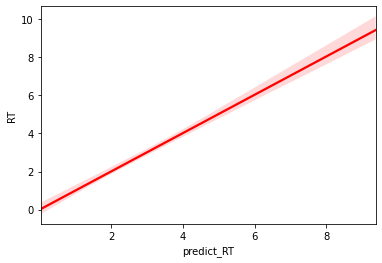

In [12]:
import pandas as pd
import numpy as np
df = pd.DataFrame({'RT':np.arange(10), 'predict_RT':np.arange(10)+np.random.normal(0,0.3,10)})
evaluate_linear_regression_plot(df)